### Задача Т2

Случайная величина имеет **экспоненциальный** закон распределения

$$
p(x)=
\begin{cases}
e^{-x}, & x \ge 0,\\
0, & x < 0
\end{cases}
$$

Сгенерируйте выборку объема (n = 25).

a)
Определить по выборке моду, медиану, размах, оценку коэффициента асимметрии.

b)
Построить эмпирическую функцию распределения, гистограмму и boxplot.

c)
Сравнить оценку плотности распределения среднего арифметического элементов выборки, полученную с помощью ЦПТ, с бутстраповской оценкой этой плотности.

d)
Найти бутстраповскую оценку плотности распределения коэффициента асимметрии и оценить вероятность того, что коэффициент асимметрии будет меньше 1.

e)
Сравнить плотность распределения медианы выборки с бутстраповской оценкой этой плотности.

## Решение:

Сначала найдем и реализуем необходимые функции.


$ F(x) = \int_{-\infty}^{x}{p(t)dt} = \int_{0}^{x}{e^{-t}dt} = 1 - e^{-x} \text{ – функция распределения} $

$ \mu_k = \frac{1}{n} \sum_{i=1}^{n} \left( x_i - \bar{x} \right)^k, \text{ – k-й центральный момент, где } $

$ \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i $

$ N(a, D) = \frac{1}{\sqrt{2 \pi D}} \ exp({-\frac{(x-a)^2}{2D}}) \text{ – функция нормального распределение} $

In [1]:
# Импортируем зависимости

import sys
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# Set style for matplotlib
plt.style.use("ggplot")

sys.path.append(os.path.abspath("../../"))

from tools import additionals, visualisation

In [2]:
# Необходимые функции

def p(x):
    return np.exp(-x) if x >= 0 else 0

def F(x):
    return 1 - np.exp(-x) if x >= 0 else 0

def mu_k(sample, k: int) -> float:
    sample_avg = np.mean(sample)
    return np.sum([(sample_i - sample_avg)**k for sample_i in sample]) / len(sample)

def normal(x, a, D):
    return (np.sqrt(2 * np.pi * D))**(-1) * np.exp(-(x-a)**2 / (2*D))

##### Для нашей случайной величины:

$ \lambda = 1 \text{ – интенсивность простейшего потока (такое название нашёл в интернете)} $

$ scale = 1 / \lambda = 1 \text{ – введём параметр} $

In [3]:
scale = 1

In [4]:
# Генерируем выборку

#np.random.seed(42)      # – для воспроизводимости результатов (опционально – без него будет каждый раз новая выборка)

n = 25                  # – число элементов выборки
X = np.random.exponential(scale=scale, size=n)

X_ordered = np.sort(X)  # – вариационный ряд

print(X)

[1.03619498 0.15141297 0.28992321 1.94247111 0.86655149 1.1963355
 0.12387939 0.39529448 0.97862475 0.6667845  0.3624525  3.97471009
 1.80225213 0.02935336 0.03931881 0.58216434 0.1438041  0.43190484
 0.66454197 3.97695705 1.76463635 0.08959719 0.35689334 0.30152407
 0.66220396]


#### а) Мода, медиана, размах, оценка коэффициента асимметрии.

$ \gamma = \frac{\mu_3}{\mu_2^{\frac{3}{2}}} \ \text{ – формула для нахождения выборочного коэффициента ассиметрии} $

In [5]:
from tabulate import tabulate

values, counts = np.unique(X, return_counts=True)
mode_index = np.argmax(counts)

def find_mode(array):
    values, counts = np.unique(array, return_counts=True)
    max_count = np.max(counts)
    
    if max_count == 1:
        return "Нет моды (все элементы уникальны)"
    
    modes = values[counts == max_count]

    return modes[0]

mode = find_mode(X)                  # – мода
median = np.median(X)               # – медиана
range_val = np.max(X) - np.min(X)   # – размах
gamma = st.skew(X)                  # – оценка коэффициента ассиметрии

table_data = [
    ["Мода", mode],
    ["Медиана", f"{median:.4f}"],
    ["Размах", f"{range_val:.4f}"],
    ["Коэф. асимметрии", f"{gamma:.4f}"]
]

print(tabulate(table_data, 
               headers=["Статистика", "Значение"], 
               tablefmt="fancy_grid",
               colalign=("left", "right")))

╒══════════════════╤═══════════════════════════════════╕
│ Статистика       │                          Значение │
╞══════════════════╪═══════════════════════════════════╡
│ Мода             │ Нет моды (все элементы уникальны) │
├──────────────────┼───────────────────────────────────┤
│ Медиана          │                            0.5822 │
├──────────────────┼───────────────────────────────────┤
│ Размах           │                            3.9476 │
├──────────────────┼───────────────────────────────────┤
│ Коэф. асимметрии │                            1.9092 │
╘══════════════════╧═══════════════════════════════════╛


#### b) Эмпирическая функция распределения, гистограмма и boxplot

##### Начнём с эмпирической функции:

$ \widetilde{F}(x) = \frac{m(x)}{n}, \ \text{где } m(x) \text{ – число элементов выборки, которые меньше } x $

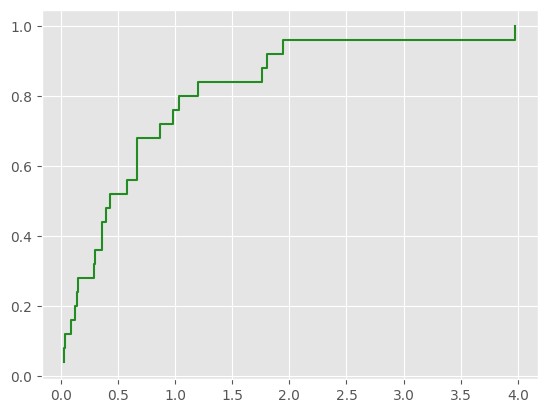

In [6]:
plt.step(
    X_ordered,
    np.arange(1,1+n) / n,
    color='forestgreen',
    linestyle='-'
)
plt.show()

##### Гистограмма

$ K = 1 + \log_2{n} \ \text{ – правило Стерджесса для определения оптимального числа интервалов гистограммы.} $

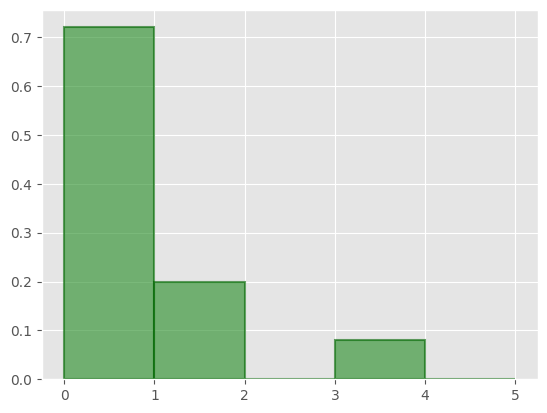

In [7]:
K = int(1 + np.log2(n))

plt.hist(
    X_ordered,
    bins=K,
    range=(0, 5),
    density=True,
    color='forestgreen',
    edgecolor='darkgreen',
    linewidth=1.5,
    alpha=0.6
)
plt.show()

##### Boxplot

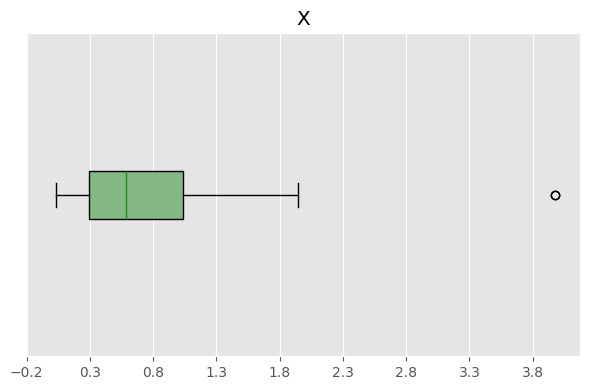

In [8]:
X_ = np.array([X, np.zeros_like(X)]).T

visualisation.visualize_distribution(
    points=X_,
    diagram_type=visualisation.DiagramTypes.Boxplot,
    diagram_axis=visualisation.AxisNames.X
)

#### c) Сравниваем оценку плотности распределения среднего арифметического элементов выборки, полученную с помощью ЦПТ, с бутстраповской оценкой этой плотности.

<img src="mean_cpt.png" width="70%">

Теперь воспользуемся bootstrap.

In [9]:
from typing import Callable

def bootstrap(array: np.ndarray, func: Callable, N: int = 1000):
    bootstrap_values = []
    size = len(array)
    for i in range(N):
        bt_sample = np.random.choice(array, size=size, replace=True)
        bootstrap_values += [func(bt_sample)]
    return np.array(bootstrap_values)

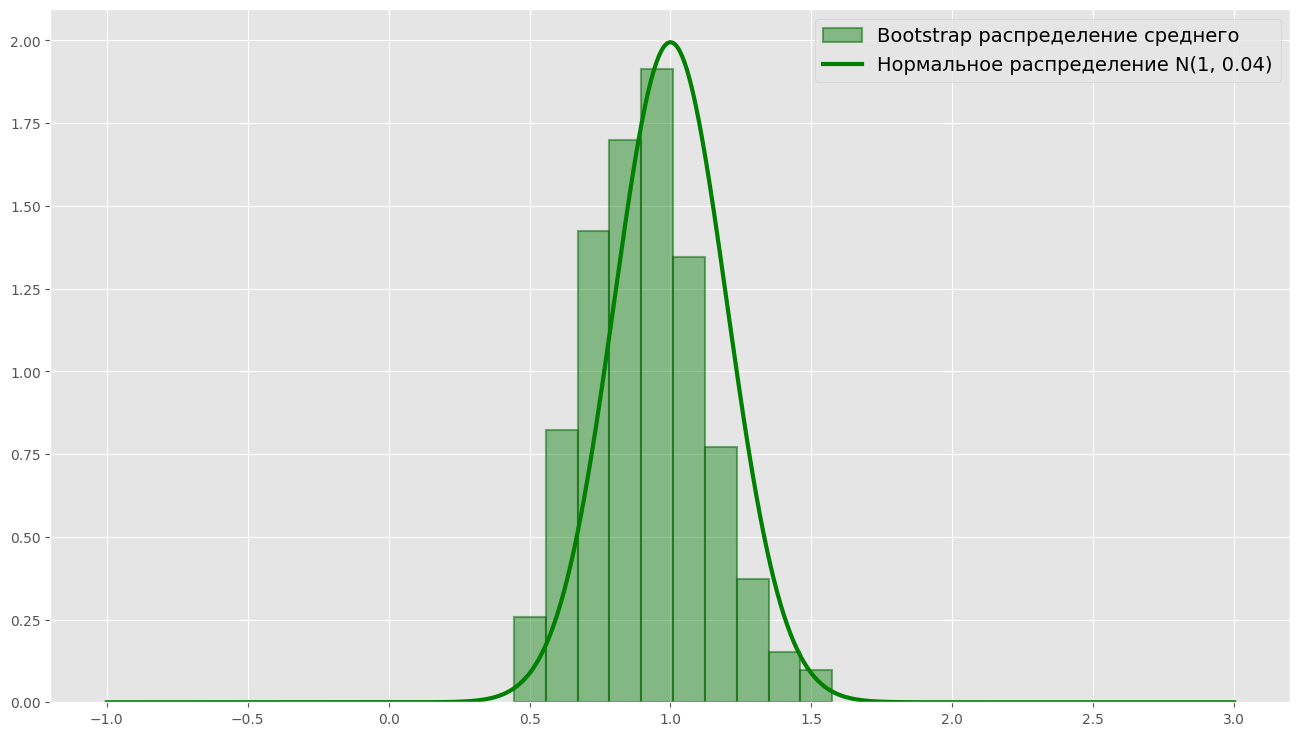

In [10]:
# Bootstrap для среднего арифметического элементов 
N = 1000

a = 1
D = 1/n

bt = bootstrap(X, np.mean, N)

fig, axs = plt.subplots(1, 1, figsize=(16,9))

K = int(1 + np.log2(N))

axs.hist(
    bt,
    bins=K,
    density=True,
    alpha=0.5,
    color='forestgreen',
    edgecolor='darkgreen',
    linewidth=1.5,
    label='Bootstrap распределение среднего'
)

x = np.linspace(a-2, a+2, 1000)
norm_x = normal(x, a, D)

axs.plot(
    x,
    norm_x,
    linewidth=3,
    color='green',
    label=f'Нормальное распределение N({a}, {D})'
)

axs.legend(fontsize=14)
plt.show()

Бутстраповское распределение для среднего центрируется вокруг выборочного среднего $\tilde{X}$, поскольку он строится относительно эмпирического распределения.

Таким образом, при размере выборки $ n = 25 $, само $\tilde{X}$ имеет стандартное отклонение $ \frac{1}{\sqrt{n}} = 0.2. $, поэтому оно может заметно отклоняться от истинного математического ожидания, равного $ 1 $.

#### d) Найдём бутстраповскую оценку плотности распределения коэффициента асимметрии и оценим вероятность того, что коэффициент асимметрии будет меньше 1.

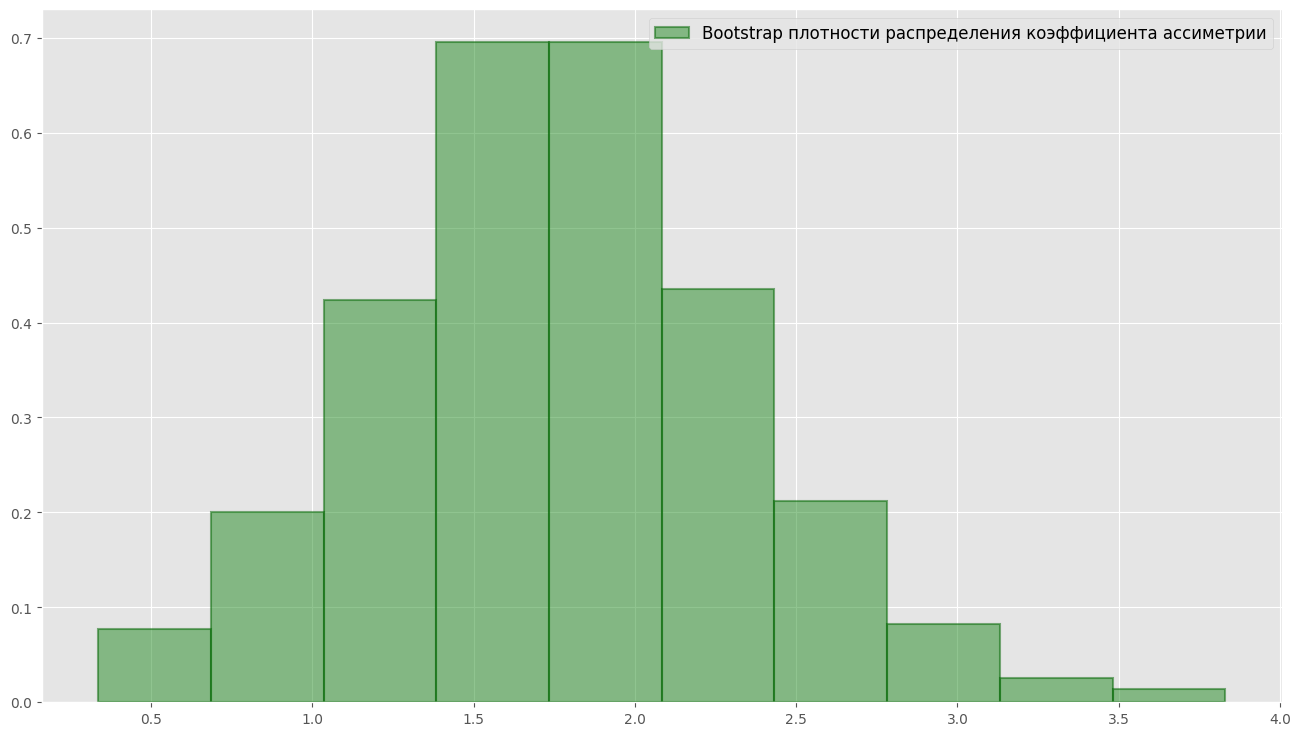

In [11]:
# Bootstrap для оценки плотности распределения коэффициента ассиметрии 
N = 1000
K = int(1 + np.log2(N))

bt = bootstrap(X, st.skew, N)

fig, axs = plt.subplots(1, 1, figsize=(16,9))

axs.hist(
    bt,
    bins=K,
    density=True,
    alpha=0.5,
    color='forestgreen',
    edgecolor='darkgreen',
    linewidth=1.5,
    label='Bootstrap плотности распределения коэффициента ассиметрии'
)

axs.legend(fontsize=12)
plt.show()

Оценка вероятности того, что коэффициент асимметрии будет меньше 1.

In [12]:
p_skew = np.sum([1 if bt[i] < 1 else 0 for i in range(len(bt))]) / N
print("P(skew < 1) =", p_skew)

P(skew < 1) = 0.09


#### e) Сравниваем плотность распределения медианы выборки с бутстраповской оценкой этой плотности.

Медиана это одна из порядовых статистик. Функцию распределения мы уже знаем. Найдем теперь плотность распределения k-ой порядковой статистики.

<img src="k_distr.png" width="70%">

In [13]:
from math import factorial as fct

def kth_dens(t, k):
    return fct(n) / (fct(k-1) * fct(n-k)) * F(t)**(k-1) * (1 - F(t))**(n-k) * p(t)

k_med = n // 2 + 1      # – номер k для медианы

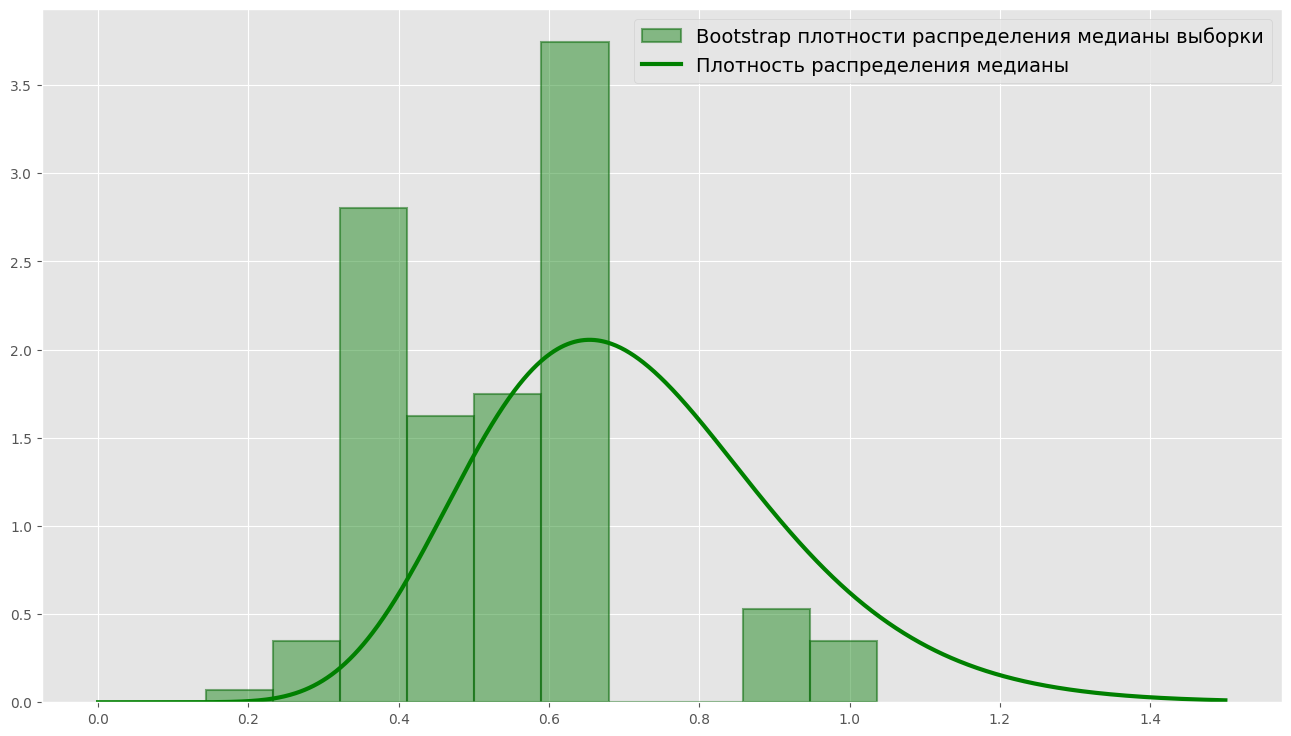

In [36]:
# Bootstrap для оценки плотности распределения медианы выборки
N = 1000
K = int(1 + np.log2(N))

bt = bootstrap(X, np.median, N)

fig, axs = plt.subplots(1, 1, figsize=(16,9))

axs.hist(
    bt,
    bins=K,
    density=True,
    alpha=0.5,
    color='forestgreen',
    edgecolor='darkgreen',
    linewidth=1.5,
    label='Bootstrap плотности распределения медианы выборки'
)

x = np.linspace(0, 1.5, 1000)
y = [kth_dens(x_i, k_med) for x_i in x]
axs.plot(
    x,
    y,
    linewidth=3,
    color='green',
    label='Плотность распределения медианы'
)

axs.legend(fontsize=14)
plt.show()